# Análise exploratória e Market Basket Analisys com APRIORI (R)

Vamos trabalhar com um dataset de vendas on-line de alguns países da Europa. Ao final, teremos conhecimento das associações existentes entre os itens mais vendidos, o que poderá nos levar à um modelo de recomendação de compra.


## Sobre Market Basket Analisys


Trata-se de de uma das estratégias mais utilizadas para impulsionar venda no varejo (há anos utilizadas por Big Techs como Amazon, Netflix) e, atualmente, em grande expensão em empresas de vendas on-line, devido a simplicidade de apuração e aplicadas os resultados. Esta estratégia minera padrões de associação entre itens (no caso, produtos comprados de forma simultânea), indicado, ao final que:
        
        - quem comprou x, também comprará y
        
O Market Basket Analisys é um exemplo de algoritmo de machine learning pertencente ao grupo de aprendizado não supervisionado. Assim, não precisaremos treinar o modelo, ou aplicar métricas de validação, visto que, ao final, teremos associações desenhadas tendo em vista algumas características dos produtos, e sua similaridade com outros compras.

Para saber mais, [clique aqui](https://rstudio-pubs-static.s3.amazonaws.com/707718_af6a0861e5ef4e3d928d1f4fdee9dd3f.html)


## Sobre o conjunto de dados

Fonte: [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx)

Este dataset contém dados de varejo, e fornece dados de transações de um site sediano no Reino Unido.

## Motivação

Com base nas transações já registradas, queremos recomendar ao cliente compras que são bastante prováveis.

## Iniciando análise:

In [145]:
# Instalando pacotes
install.packages('htmlwidgets')
install.packages('data.table')
install.packages('arules')
install.packages('arulesViz')
install.packages('tidyr')
install.packages('reshape2')
install.packages('dplyr')
install.packagespa('plotrix')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [146]:
# Carregando pacotes

library(htmlwidgets)
library(data.table)
library(arules)
library(tidyr)
library(reshape2)
library(dplyr)
library(arulesViz)
library(plotrix)

In [147]:
#Suprimindo warnings
options(war = -1)

### Carregando e visualizando dados

In [148]:
#Carregando dados

dados = read.csv('../input/retailcsv/retail.csv')

#retirando coluna 'x'
dados = dados[, -c(1, 9)]

head(dados)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<int>
1,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583
2,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583
3,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583
4,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583
5,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583
6,536370,10002,INFLATABLE POLITICAL GLOBE,48,2010-12-01 08:45:00,0.85,12583


In [149]:
tail(dados)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<int>
8552,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,2011-12-09 12:50:00,4.15,12680
8553,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680
8554,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680
8555,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680
8556,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680
8557,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680


Verificando atributos

In [150]:
colnames(dados)

[1] "InvoiceNo"   "StockCode"   "Description" "Quantity"    "InvoiceDate"
[6] "UnitPrice"   "CustomerID"

Dicionário de dados

| Coluna | Descrição|
|--------|----------|
|InvoiceNo| Número da nota fiscal|
|StockCode| Código do produto no estoque|
|Description| Descrição do produto|
|Quantity| Quantidade comprada|
|InvoiceDate| Data da Compra|
|UnitPrice| Preço unitário|
|CustomerID| Id do cliente|



Trata-se de base de dados de um site de vendas no varejo, contendo produtos de diversas categorias. Não usaremos todas os atributos para realizar o Market Basket Analisys; mas, para termos conhecimento da base de dados, podemos realizar uma análise descritiva.

## Análise exploratória de dados

### Pré-processamento

In [151]:
# Função para apontar na's e valores únicos por colunas
info_cols = function(data.frame){

  na_s = colSums(is.na(data.frame))
  unique_v = apply(data.frame, 2, n_distinct)
  return(data.frame(na = na_s, valores_unicos = unique_v))
}

In [152]:
info_cols(dados)

,na,valores_unicos
,<dbl>,<int>
InvoiceNo,0,461
StockCode,0,1543
Description,0,1565
Quantity,0,77
InvoiceDate,0,461
UnitPrice,0,97
CustomerID,66,88


Percebe-se existir dados nulos no atributo 'CustomerID'

In [153]:
head(dados[is.na(dados$CustomerID), ])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<int>
3468,556924,82552,WASHROOM METAL SIGN,1,2011-06-15 14:14:00,1.45,NA
3469,556924,21165,BEWARE OF THE CAT METAL SIGN,1,2011-06-15 14:14:00,1.69,NA
3470,556924,47503A,ASS FLORAL PRINT MULTI SCREWDRIVER,1,2011-06-15 14:14:00,1.25,NA
3471,556924,23154,SET OF 4 JAM JAR MAGNETS,3,2011-06-15 14:14:00,2.08,NA
3472,556924,23156,SET OF 5 MINI GROCERY MAGNETS,3,2011-06-15 14:14:00,2.08,NA
3473,556924,21442,GREEN BIRDHOUSE DECORATION,2,2011-06-15 14:14:00,0.85,NA


A princípio, estes NA's não seriam problema para o Market Basket Analisys, vez que iremos agrupas as compras por nota fiscal, e não por cliente. Mas, como iremos conduzir uma breve análise exploratória dos dados, e, o atributo em questão pode nos interessar, é interessante eliminá-los do dataset (observe que se trata de dado categórico, não sendo possível sua substituição).

Vamos observar o quanto este dados compromete o conjunto.

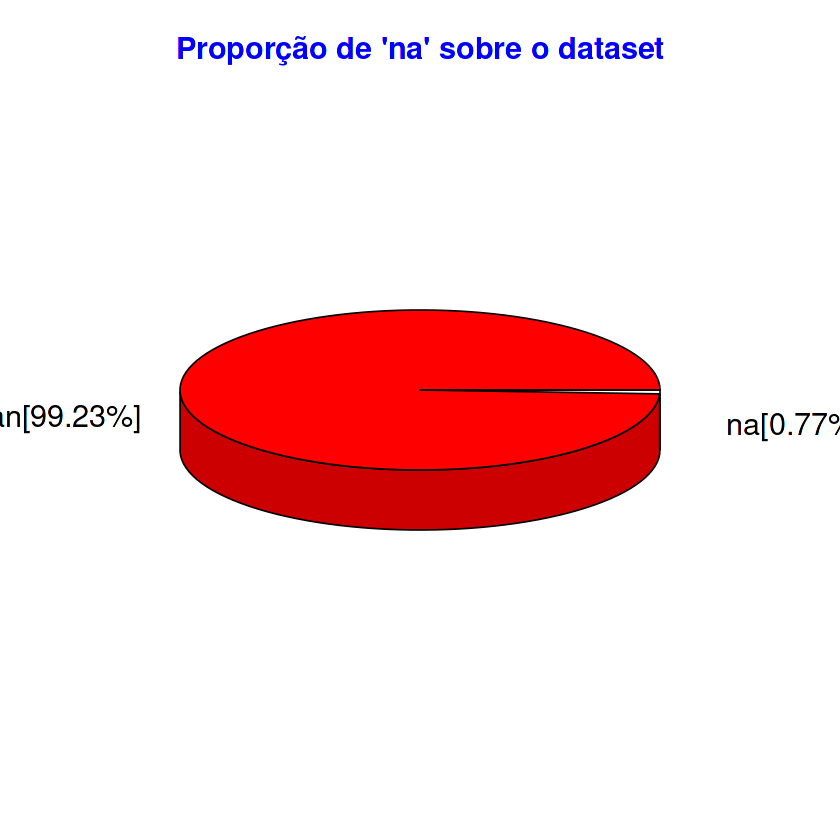

In [154]:
#calculando proporção de dados nulos
values = c(clean = round((nrow(dados)-sum(is.na(dados)))/nrow(dados)*100, 2), na = round(sum(is.na(dados))/nrow(dados)*100,2))

names_v= c(paste(names(values)[1],'[',values[1],'%', ']',sep = ""), paste(names(values)[2],'[', values[2],'%', ']', sep = ""))

# Criando gráfico
pie3D(values, labels = names_v,
     main = "Proporção de 'na' sobre o dataset", cex.main = 1.5, col.main = 'blue', radius = 0.8,
     labelcex = 1.5)

In [155]:
# eliminando NA's e visualizando resultado
dados = na.omit(dados)


Verificando 'InvoiceN'. Como iremos agrupar as compras por nota fiscal, vamos nos certificar as características da coluna. Observe que, tem-se apenas dados numéricos, a princípio. Portanto, iremos fazer a conversão do tipo para 'integer'. Antes, no entanto, vamos verificar se não há caracteres (do tipo character), evitando a inserção de NA's no dataset.

In [156]:
#verificando características do atributro InvoiceNO
indices = grep("[A-Za-z]", dados$InvoiceNo)

message(length(indices), " linhas do atributo 'InvoiveNo' possuem string.")
dados[indices, ]

149 linhas do atributo 'InvoiveNo' possuem string.



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<int>
179,C537893,22450,SILK PURSE BABUSHKA BLUE,-1,2010-12-09 10:14:00,3.35,12721
180,C537893,22634,CHILDS BREAKFAST SET SPACEBOY,-2,2010-12-09 10:14:00,9.95,12721
181,C537893,22630,DOLLY GIRL LUNCH BOX,-2,2010-12-09 10:14:00,1.95,12721
355,C539104,22662,LUNCH BAG DOLLY GIRL DESIGN,-3,2010-12-16 10:38:00,1.65,12494
357,C539114,22667,RECIPE BOX RETROSPOT,-3,2010-12-16 11:24:00,2.95,12494
440,C540151,21843,RED RETROSPOT CAKE STAND,-1,2011-01-05 11:13:00,10.95,12494
441,C540156,21843,RED RETROSPOT CAKE STAND,-1,2011-01-05 11:36:00,10.95,12683
562,C540367,POST,POSTAGE,-3,2011-01-06 16:17:00,18.00,12413
696,C540853,22634,CHILDS BREAKFAST SET SPACEBOY,-1,2011-01-12 09:52:00,9.95,12413


Observa-se o profixo "C", em 149 linhas do nosso dataset. Observa-se, também, que, nestas linhas, os dados no atributo 'Quantity' são representados como negativos, ao contráriod e vendas normais, representando reposição de estoque.

Percebe-se, portanto, que as notas fiscais com prefixo "C" representam cancelamentos. Este cancelamentos não nos interessam, pois queremos conhecer as associações de produtos efetivamente comprados.

Vamos eleiminar as linhas que correspondam a compras canceladas.

In [157]:
tail(dados)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<int>
8552,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,2011-12-09 12:50:00,4.15,12680
8553,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680
8554,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680
8555,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680
8556,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680
8557,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680


In [158]:
#removendo compras canceladas

dados_clean = dados[-indices, ]

In [159]:
#Conferindo resultado
indices_new = grep("[A-Za-z]", dados_clean$InvoiceNo)
message(length(indices_new), " linhas do atributo 'InvoiveNo' possuem string.")

0 linhas do atributo 'InvoiveNo' possuem string.



Vamos seguir adequando os dados ao tipo correto

In [160]:
# Atribuindo tipo correto ao dado
dados_clean$Quantity = as.integer(dados_clean$Quantity)
dados_clean$InvoiceDate = as.Date(dados_clean$InvoiceDate)
dados_clean$StockCode = as.integer(dados_clean$StockCode)
dados_clean$InvoiceNo = as.integer(dados_clean$InvoiceNo)

Observe que o casting do tipo dos dados inseriu NAs no dataset, vamos verificar.

In [161]:
#visualizando NAs em StockCode (depois do casting)

head(dados_clean[is.na(dados_clean$StockCode), ])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
,<int>,<int>,<chr>,<int>,<date>,<dbl>,<int>
20,536370,NA,POSTAGE,3,2010-12-01,18.00,12583
27,536852,NA,POSTAGE,1,2010-12-03,18.00,12686
28,536974,NA,EDWARDIAN PARASOL BLACK,9,2010-12-03,5.95,12682
29,536974,NA,EDWARDIAN PARASOL PINK,3,2010-12-03,5.95,12682
43,536974,NA,POSTAGE,2,2010-12-03,18.00,12682
76,537065,NA,GREEN 3 PIECE POLKADOT CUTLERY SET,6,2010-12-05,3.75,12567


In [162]:
#visualizando NAs em StockCode (antes do casting)

head(dados[is.na(dados_clean$StockCode), ])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<int>
20,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583
27,536852,POST,POSTAGE,1,2010-12-03 09:51:00,18.00,12686
28,536974,15056BL,EDWARDIAN PARASOL BLACK,9,2010-12-03 13:59:00,5.95,12682
29,536974,15056P,EDWARDIAN PARASOL PINK,3,2010-12-03 13:59:00,5.95,12682
43,536974,POST,POSTAGE,2,2010-12-03 13:59:00,18.00,12682
76,537065,84997A,GREEN 3 PIECE POLKADOT CUTLERY SET,6,2010-12-05 11:57:00,3.75,12567


Verifica-se que, não é possível a conversão do atributo 'StockCode' para integer, haja vista a presença de dados do tipo 'character'.

Observando o dado especificamente, percebe-se que entre os produtos descritos, há um com identificação de 'POSTAGE', com 'StockCode' 'POST', diferente dos demais produtos que refecem uma numeração, no inventário da empresa. Parece tratar-se, tão puramente, do frete contratado pelo usuário no momento da compra. Vamos, aproveitar, e pesquisar a possível existência de demais itens no atributo analisado, que contenham strings.



Como medida, eliminaremos todas as linhas que contenham 'POST' no 'StockCode'. Esta decisão preservará os dados, vez que evitaremos as perdas que que seriam ocasionadas pela simples eliminação das linhas. Além do mais, os dados 'StockCode' para ter muito valor para nossa análise.

Observe, nos indices 28,29 que se trata do mesmo produto, mas com características diferentes. Em ambos o prefixo do 'StockCode' é 15056. Ao que parece, poderemos agrupar melhor os dados, enriquecendo a análise, se usarmos esse dado. Mais um movito para não eliminar o atributo 'StockCode' do dataset.

Vamos eliminar as linhas com "POST", conforme mencionado, e observar melhor o atributo 'StockCode'

Para isso, precisamos restaurar o dataset, visto que inserimos NAs onde não há dados numéricos

In [163]:
# Restaudando dataset dados_clean

dados_clean = dados[-indices, ]

In [164]:
head(dados_clean)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<int>
1,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583
2,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583
3,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583
4,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583
5,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583
6,536370,10002,INFLATABLE POLITICAL GLOBE,48,2010-12-01 08:45:00,0.85,12583


In [165]:
# verificando dados que contém strings no código

indices_no_numeric = grep('[a-zA-Z]', dados_clean$StockCode)

head(dados_clean[indices_no_numeric, ])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<int>
20,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583
27,536852,POST,POSTAGE,1,2010-12-03 09:51:00,18.00,12686
28,536974,15056BL,EDWARDIAN PARASOL BLACK,9,2010-12-03 13:59:00,5.95,12682
29,536974,15056P,EDWARDIAN PARASOL PINK,3,2010-12-03 13:59:00,5.95,12682
43,536974,POST,POSTAGE,2,2010-12-03 13:59:00,18.00,12682
76,537065,84997A,GREEN 3 PIECE POLKADOT CUTLERY SET,6,2010-12-05 11:57:00,3.75,12567


In [166]:
# Mapeando linhas com "POST"

message("Temos ", sum(dados_clean$StockCode == 'POST'), " contendo 'POST', em nosso dataset")

Temos 300 contendo 'POST', em nosso dataset



In [167]:
# Eliminando linhas com "POST"

dados_clean = dados_clean[dados_clean$StockCode != 'POST', ]

message("Temos ", sum(dados_clean$StockCode == 'POST'), " contendo 'POST', em nosso dataset")

Temos 0 contendo 'POST', em nosso dataset



Removemos as linhas contendo 'POST', mas, ainda temos dados, no atributo 'StockCode', contendo strings, que, aparentemente, representam variações de um único produto, como a cor.

Vamos verificar.

In [168]:
#Mapeando StockCode

table(factor(nchar(dados_clean$StockCode)))


   1    2    5    6    7 
   6    2 7656  360   18 

In [169]:
#Visualizando dados com 1 string

dados_clean[nchar(dados_clean$StockCode) == 1, ]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<int>
2132,548913,M,Manual,1,2011-04-05 09:45:00,1136.30,12669
2705,553357,M,Manual,2,2011-05-16 14:17:00,15.00,12684
6531,573077,M,Manual,1,2011-10-27 14:13:00,4161.06,12536
6533,573080,M,Manual,1,2011-10-27 14:20:00,4161.06,12536
6813,574252,M,Manual,1,2011-11-03 13:24:00,0.00,12437
6886,574506,M,Manual,1,2011-11-04 13:24:00,3.95,12577


In [170]:
#Eliminando "M"
dados_clean = dados_clean[dados_clean$StockCode != 'M', ]

message("Temos ", sum(dados_clean$StockCode == 'M'), " contendo 'M', em nosso dataset")

Temos 0 contendo 'M', em nosso dataset



In [171]:
#Visualizando dados com 2 strings
dados_clean[nchar(dados_clean$StockCode) == 2, ]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<int>
431,539688,C2,CARRIAGE,1,2010-12-21 11:00:00,150,12678
2998,554826,C2,CARRIAGE,2,2011-05-26 14:53:00,18,12493


In [172]:
#Eliminando 'C2'
dados_clean = dados_clean[dados_clean$StockCode != 'C2', ]

message("Temos ", sum(dados_clean$StockCode == 'C2'), " contendo 'C2', em nosso dataset")

Temos 0 contendo 'C2', em nosso dataset



In [173]:
#Mapeando StockCode para confirmar a eliminação dos dados

table(factor(nchar(dados_clean$StockCode)))


   5    6    7 
7656  360   18 

Agora, eliminaremos o atributo 'StockCode' do dataset, vez que utilizaremos a descrição dos produtos para encontrar as associações.

In [174]:
# Eliminando 'StockCode'

dados_clean = dados_clean[, -2]

In [175]:
head(dados_clean)

,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
,<chr>,<chr>,<int>,<chr>,<dbl>,<int>
1,536370,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583
2,536370,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583
3,536370,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583
4,536370,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583
5,536370,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583
6,536370,INFLATABLE POLITICAL GLOBE,48,2010-12-01 08:45:00,0.85,12583


In [177]:
# Atribuindo tipo correto ao dado
dados_clean$InvoiceDate = as.Date(dados_clean$InvoiceDate)


## Data Wrangling

In [178]:
# Visualizando informações no dataset

glimpse(dados_clean)

Rows: 8,034
Columns: 6
$ InvoiceNo   <chr> "536370", "536370", "536370", "536370", "536370", "536370"…
$ Description <chr> "ALARM CLOCK BAKELIKE PINK", "ALARM CLOCK BAKELIKE RED ", …
$ Quantity    <int> 24, 24, 12, 12, 24, 48, 24, 18, 24, 24, 24, 24, 20, 24, 24…
$ InvoiceDate <date> 2010-12-01, 2010-12-01, 2010-12-01, 2010-12-01, 2010-12-0…
$ UnitPrice   <dbl> 3.75, 3.75, 3.75, 0.85, 0.65, 0.85, 1.25, 2.95, 2.95, 1.95…
$ CustomerID  <int> 12583, 12583, 12583, 12583, 12583, 12583, 12583, 12583, 12…


In [179]:
info_cols(dados_clean)

,na,valores_unicos
,<dbl>,<int>
InvoiceNo,0,379
Description,0,1541
Quantity,0,52
InvoiceDate,0,203
UnitPrice,0,86
CustomerID,0,87


Os dados estão com o tipo correto, e sem valores nulos.


Vamos iniciar pelo atributo 'InvoiceNo'.

Trata-se da data em que a nota fiscal da compra foi faturada. Conforme visto acima, possui tipagem correta, mas não tem granularidade definida.

Inicialmente, vamos realizar o split do ano, mês e dia, para utilização futura.

In [180]:
# fazendo split
dados_clean$InvoiceDate2 = dados_clean$InvoiceDate
dados_clean = separate(dados_clean, 'InvoiceDate2', into = c("ano", "mes", "dia"), sep = "-")

# aplicando tipo
dados_clean$ano = as.integer(dados_clean$ano)
dados_clean$mes = as.integer(dados_clean$mes)
dados_clean$dia = as.integer(dados_clean$dia)

In [181]:
# Verificando os anos disponívels no dataset
unique(dados_clean$ano)

[1] 2010 2011

In [182]:
head(dados_clean)

,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,ano,mes,dia
,<chr>,<chr>,<int>,<date>,<dbl>,<int>,<int>,<int>,<int>
1,536370,ALARM CLOCK BAKELIKE PINK,24,2010-12-01,3.75,12583,2010,12,1
2,536370,ALARM CLOCK BAKELIKE RED,24,2010-12-01,3.75,12583,2010,12,1
3,536370,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01,3.75,12583,2010,12,1
4,536370,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01,0.85,12583,2010,12,1
5,536370,STARS GIFT TAPE,24,2010-12-01,0.65,12583,2010,12,1
6,536370,INFLATABLE POLITICAL GLOBE,48,2010-12-01,0.85,12583,2010,12,1


Os atributos 'Quantity' e 'UnitPrice' possuem tipagem correta.

Estes dados representam a quantidade comprada e preço unitário, podemos utilizá-los para enriquecer a base de dados com:

    - total de compra
    
    - analisar retornos
    
    - etc

In [183]:
#inserindo total de vendas

dados_clean$total = with(data = dados_clean, Quantity * UnitPrice)

In [184]:
# ordenando por data

dados_clean = dados_clean %>% arrange(InvoiceDate)

In [185]:
head(dados_clean)

,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,ano,mes,dia,total
,<chr>,<chr>,<int>,<date>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
1,536370,ALARM CLOCK BAKELIKE PINK,24,2010-12-01,3.75,12583,2010,12,1,90.0
2,536370,ALARM CLOCK BAKELIKE RED,24,2010-12-01,3.75,12583,2010,12,1,90.0
3,536370,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01,3.75,12583,2010,12,1,45.0
4,536370,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01,0.85,12583,2010,12,1,10.2
5,536370,STARS GIFT TAPE,24,2010-12-01,0.65,12583,2010,12,1,15.6
6,536370,INFLATABLE POLITICAL GLOBE,48,2010-12-01,0.85,12583,2010,12,1,40.8


## Visualização de dados

Como o foco desta análise não é explorar o dados, e obter insights a partir de suas informações estatísticas (mas, obter recomendações de compras), vamos utilizar o *base plot system* do R para esta finalidade.

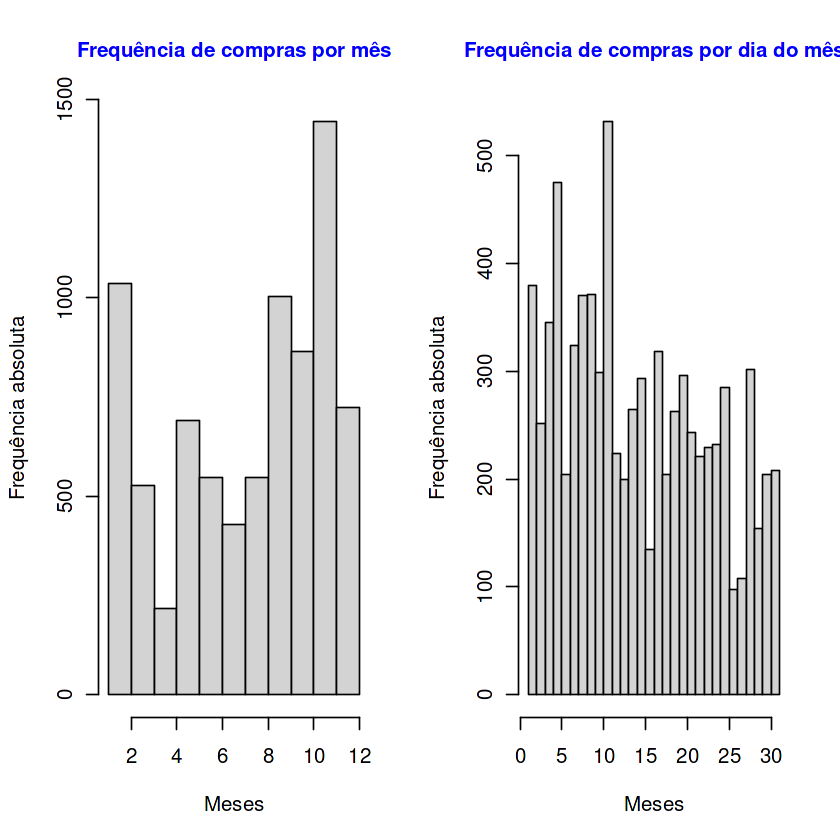

In [186]:
#Visualizando frequências de mês e dia (obs: não se trata do total de compras, mas a quantidade de sua ocorrência)

par(mfrow = c(1,2))
hist(dados_clean$mes, breaks = 12,
    main= 'Frequência de compras por mês', col.main = 'blue', cex.main = '1',
    xlab = 'Meses', ylab = 'Frequência absoluta')

hist(dados_clean$dia, breaks = 31,
    main= 'Frequência de compras por dia do mês', col.main = 'blue', cex.main = '1',
    xlab = 'Meses', ylab = 'Frequência absoluta')

par(mfrow = c(1,1))

As maiores frequências estão nos meses de janeiro, setembro e dezembro. E, no geral, a maior parte das vendas ocorre nos 10 primeiros dias. São informações importantes para:

    1. Intensificar o marketing nestes dias, vez que há maior propensão de compra, pelos clientes
    2. Investigar o motivo deste comportamente. Exemplo, se os clientes não compram depois do dia 10, porque seu salário acabou, a empresa poderia oferecer condições no cartão de crédito, pix pré-programado, etc.

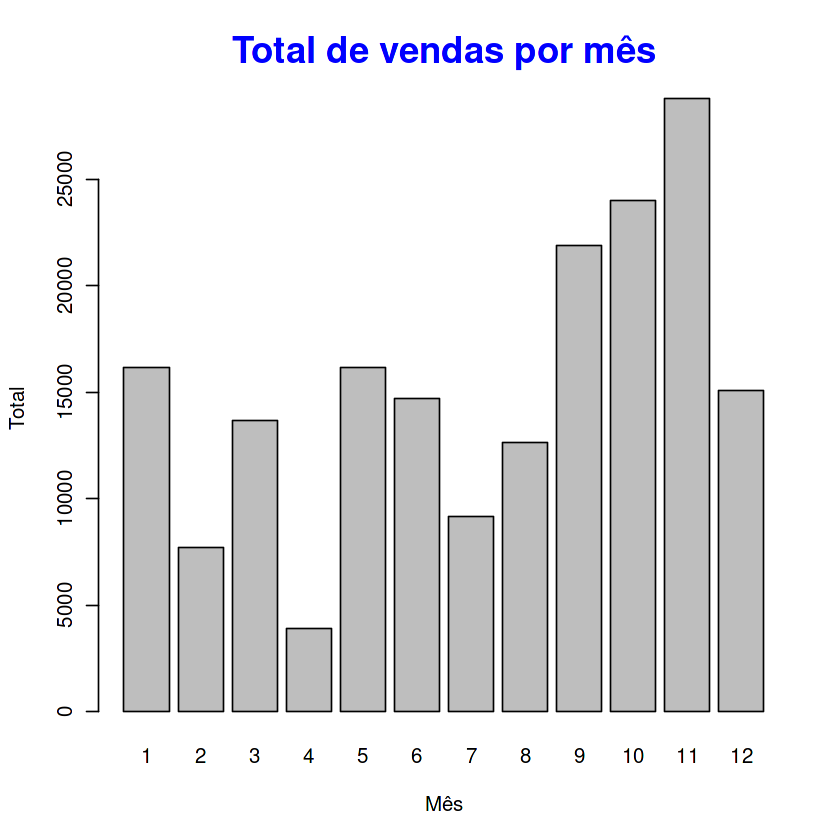

In [187]:
# Total de receita, por mês.

dados_clean %>% select(mes, total) %>%
         group_by(mes) %>% summarise(total_por_mes = sum(total)) %>% with(barplot(total_por_mes ~ mes, xlab = 'Mês', ylab = 'Total', 
                                                                                 main = 'Total de vendas por mês', cex.main = 1.8, col.main = 'blue'))

In [188]:
# Apurando total de itens por NF
total_itens_por_nf = dados_clean %>% select(InvoiceNo) %>% group_by(InvoiceNo) %>% table() %>% data.frame()

colnames(total_itens_por_nf) = c('InvoiceNo', 'qtd_prod')

# Apurando total de compra (R$) por NF
total_compra_por_nf = dados_clean %>% select(InvoiceNo, total) %>% group_by(InvoiceNo) %>% summarise(total = sum(total)) %>% data.frame()

ticket_medio = merge(total_itens_por_nf, total_compra_por_nf, how = 'inner', on = 'InvoiceNo') %>% mutate(ticket = round(total / qtd_prod,2))

In [189]:
# Conhecendo as top 5 compras
head(ticket_medio %>% arrange(desc(total)), 5)

,InvoiceNo,qtd_prod,total,ticket
,<fct>,<int>,<dbl>,<dbl>
1,573153,60,8460.76,141.01
2,570672,259,4279.71,16.52
3,548496,35,3243.13,92.66
4,542629,46,3174.43,69.01
5,571864,16,2503.74,156.48


In [190]:
#Top 3 produtos vendidos (valor total)

top_3 = dados_clean %>% select(Description, total) %>% group_by(Description)%>%
summarise(total = sum(total)) %>% arrange(desc(total)) %>% head(3)
top_3

Description,total
<chr>,<dbl>
RABBIT NIGHT LIGHT,7234.24
REGENCY CAKESTAND 3 TIER,2816.85
RED TOADSTOOL LED NIGHT LIGHT,2130.15


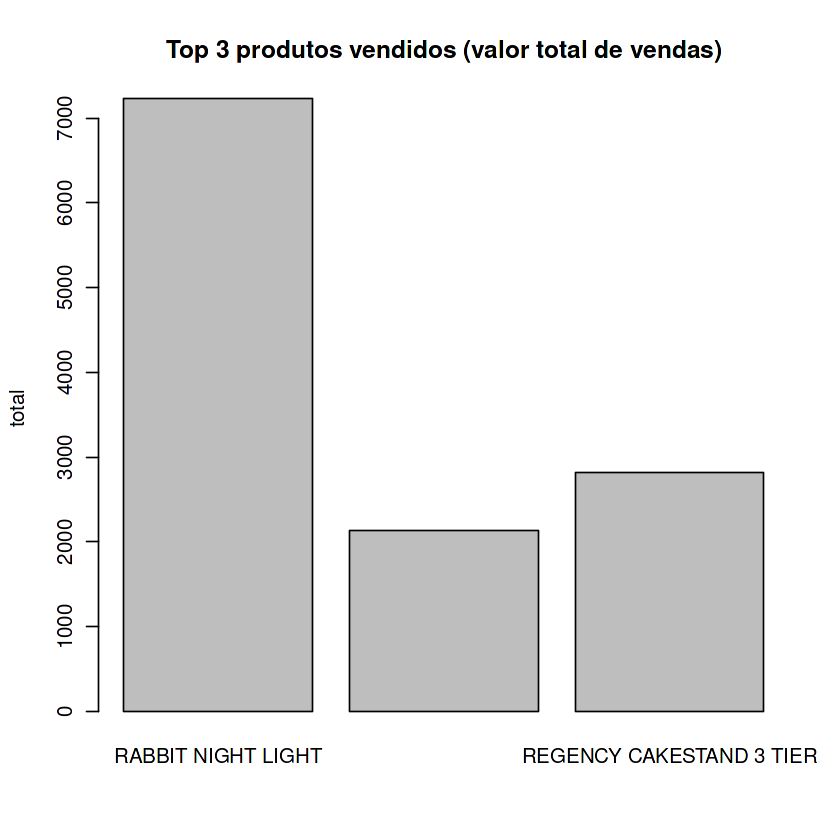

In [191]:
# Comparando top_3

barplot(data = top_3, total ~ Description, xlab = "", main = 'Top 3 produtos vendidos (valor total de vendas)')

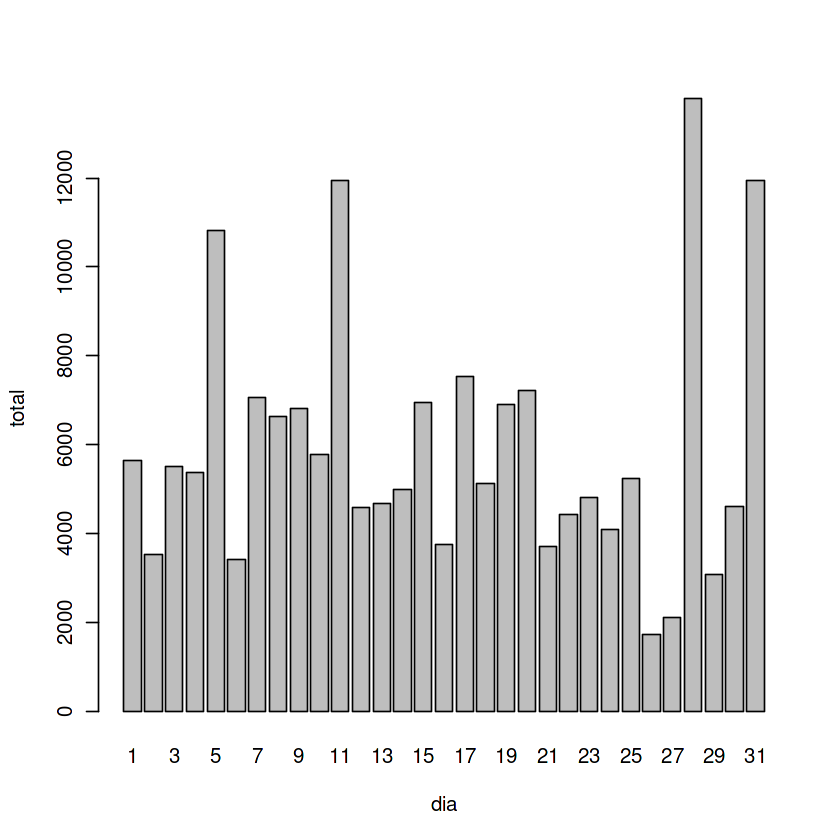

In [192]:
#total de vendas por dia

dados_clean %>% select(dia, total) %>% group_by(dia)%>%

summarise(total = sum(total)) %>% with(barplot(total ~ dia))

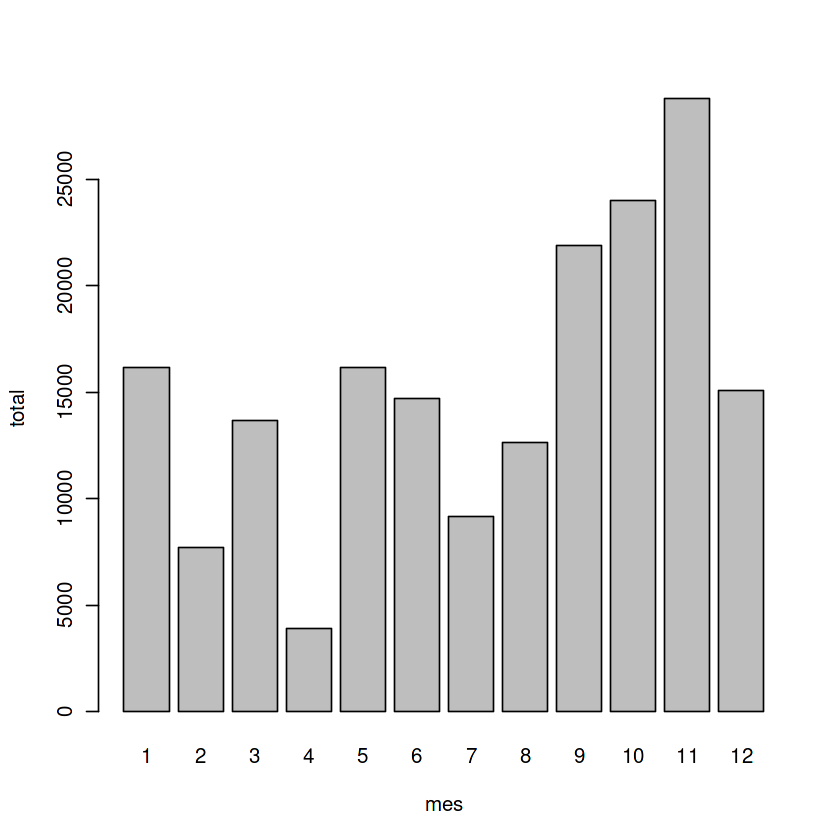

In [193]:
#total de vendas por mês

dados_clean %>% select(mes, total) %>% group_by(mes)%>%

summarise(total = sum(total)) %>% with(barplot(total ~ mes))

In [194]:
# resumo do ticket médio, por compra

summary(ticket_medio$ticket)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.16   16.61   19.84   29.48   25.35  835.20 

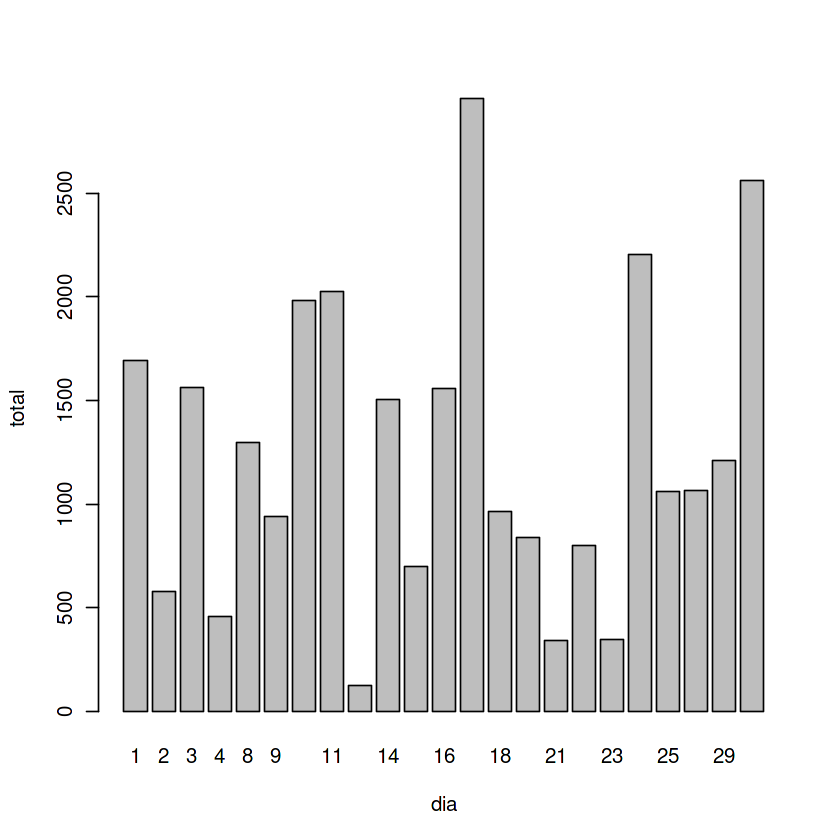

In [195]:
#Qual foi o dia, do mes 11, em que mais teve venda?

dados_clean %>% select(mes, dia, total) %>% filter(mes == 11) %>% group_by(dia) %>% summarise(total = sum(total)) %>%

with(barplot(total ~ dia))

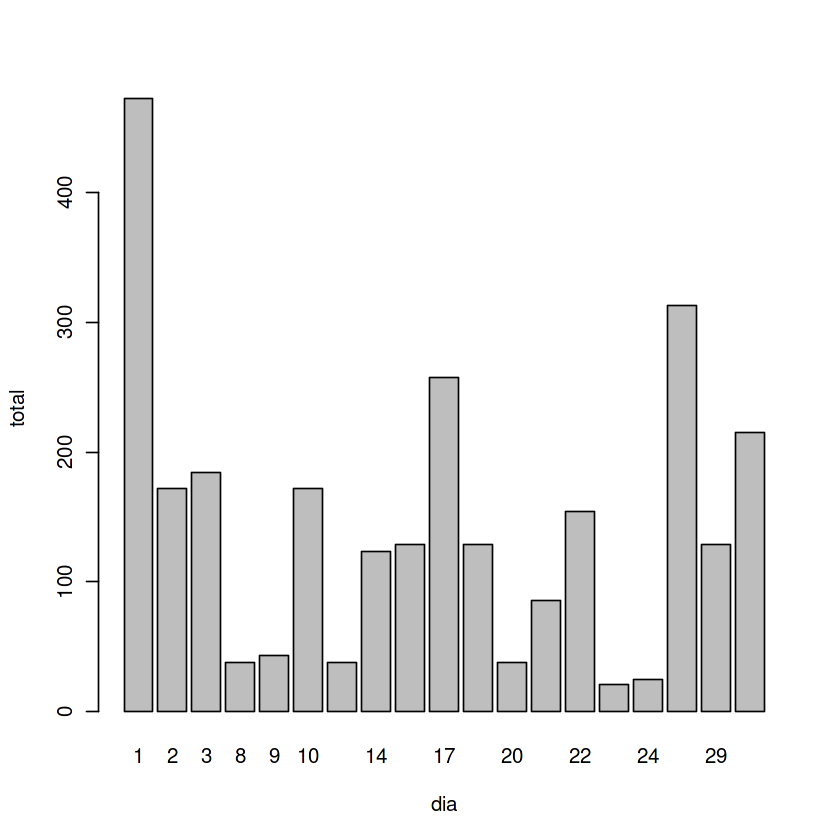

In [196]:
#total de vendas por dia / do produto mais vendido / no mês de maior venda.

dados_clean %>% select(mes, dia, total, Description) %>% filter(Description == 'RABBIT NIGHT LIGHT' & mes == 11) %>% group_by(dia)%>%

summarise(total = sum(total)) %>% with(barplot(total ~ dia))

[1] "RABBIT NIGHT LIGHT"            "REGENCY CAKESTAND 3 TIER"     
[3] "RED TOADSTOOL LED NIGHT LIGHT"

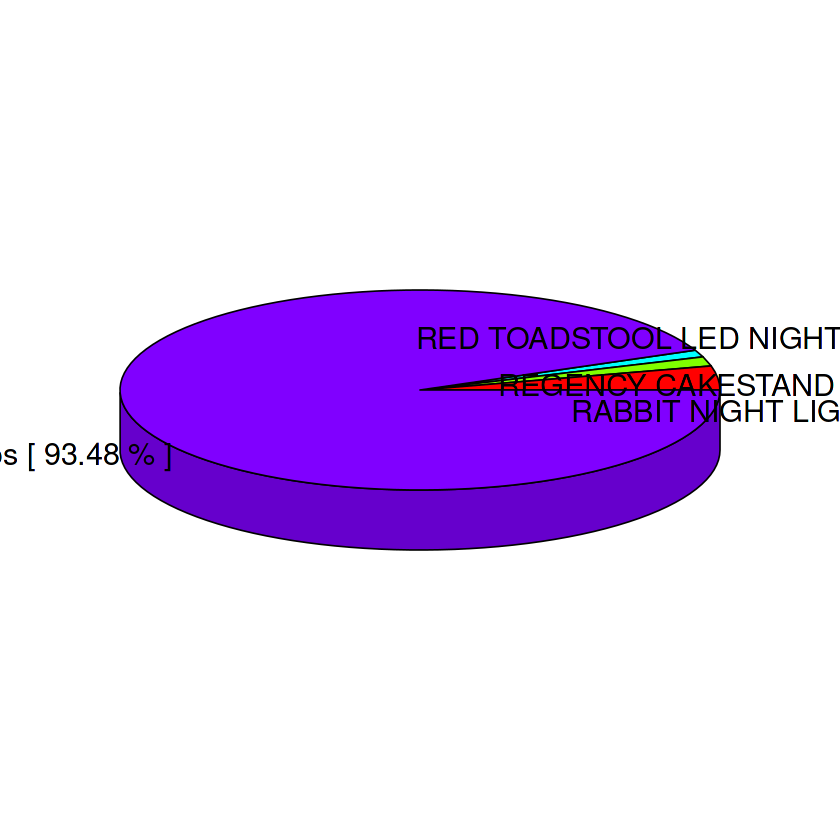

In [197]:
# Qual é a proporção do total de vendas dos top_3 em relação a todos os outros produtos

base = dados_clean %>% select(Description, total) %>% group_by(Description) %>% summarise(total = sum(total))

top_3 =  base %>% arrange(desc(total)) %>% head(3)

names_top3 = top_3$Description

names_top3

outros = data.frame('Description' = 'outros', 'total' = sum(base[base$Description != names_top3, 2]))

base = rbind(top_3, outros)

base = mutate(base, 'Proporcao' = round(base$total / colSums(base[, 'total'])*100, 2))

values = base$Proporcao

labels = paste(as.character(base$Description), '[', as.character(base$Proporcao), '%', ']')

pie3D(values, labels = labels)

Explorando os retornos mensais sobre as vendas

In [198]:
serie_vendas = dados_clean %>% select(InvoiceDate, total) %>% group_by(InvoiceDate) %>% summarise(total = sum(total))

# Calculando retorno das vendas acumuladas

serie_vendas = mutate(serie_vendas, vendas_acumuladas = cumsum(serie_vendas$total))

serie_vendas = mutate(serie_vendas, retornos = round(diff(serie_vendas$vendas_acumuladas) / lag(serie_vendas$vendas_acumuladas)*100, 2))

serie_vendas = na.omit(serie_vendas)

head(serie_vendas)

InvoiceDate,total,vendas_acumuladas,retornos
<date>,<dbl>,<dbl>,<dbl>
2010-12-03,371.38,1173.24,170.22
2010-12-05,1364.92,2538.16,112.76
2010-12-07,1322.98,3861.14,6.13
2010-12-08,155.55,4016.69,42.57
2010-12-09,1643.73,5660.42,23.10
2010-12-10,927.90,6588.32,3.46


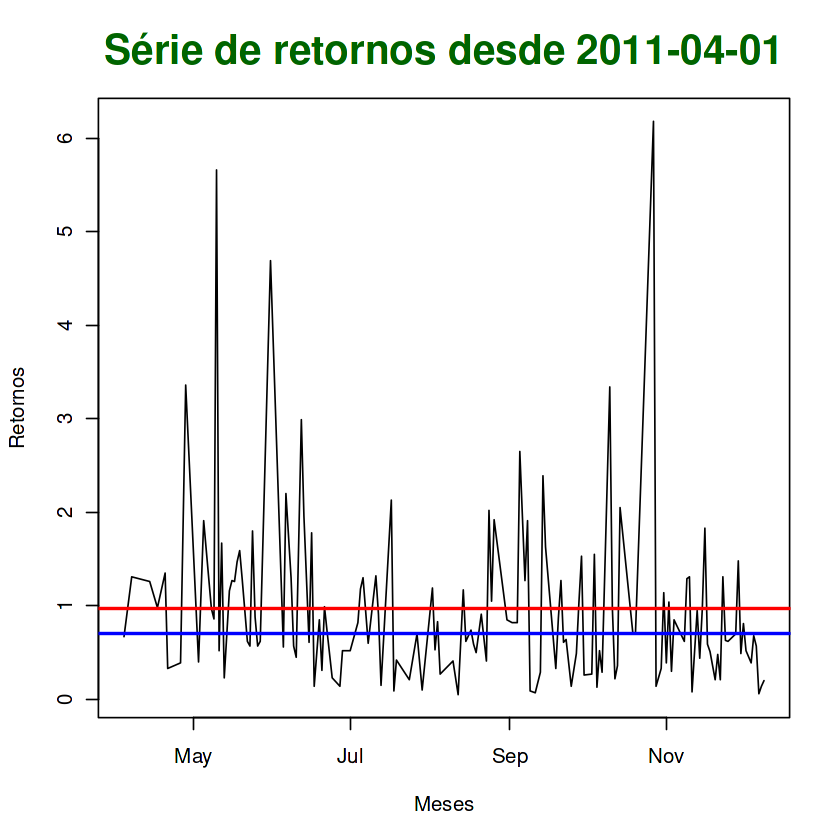

In [199]:
#encontrando média e media sobre os retornos

plotar = serie_vendas[serie_vendas$InvoiceDate > '2011-04-01', ]
plot(plotar$InvoiceDate, plotar$retornos, type = 'l', xlab = 'Meses', ylab = 'Retornos', main = 'Série de retornos desde 2011-04-01',
    cex.main = 2,  col.main = 'darkgreen')
abline(h = mean(plotar$retornos), col = 'red', lwd = 2)
abline(h = median(plotar$retornos), col = 'blue', lwd = 2)

A exploração de dos dados pode seguir infindáveis caminhos, por isso, a melhor abordagem é responder às questões de negócio levantadas nas fases iniciais do projeto.

Por isso, finalizaremos a exploração por aqui, e daremos seguinto a contrução das recomendações de compra.

## Machine Learning

Vamos iniciar a investigação das regras de associação deste dataset, usando o algoritmo ARIORI.

Este algoritmo minera associações entre os dados. Conforme mencionado no início da análise, nossso objtivo com o MBA é encontrar associações entre compras de consumidores.

tendo em vista o tamanho dos dados, usaremos alguns filtros para selecionar as mais fortes de acordo com os parâmetros mais usados em MBA:

    - support = este parâmetro nos diz o quão frequente é um item (ou um conjunto), e faz isso através do quociente da seguinte divisão (transaões com x,y) / (total de transações) 
    
    - confidence = este parâmetro retorna a probabilidade de compra de y, quando x é comprado, pela seguinte fórmula (transações com x, y) / (transações com x)
    
    - lift = este parâmetro indica o quanto aumentou a confiança de que y será comprado, quando x também for: ((transações com x, y) / (transações com x)) / (transações contendo y)


### Preparação dos dados para o algoritmo

In [200]:
tail(dados_clean)

,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,ano,mes,dia,total
,<chr>,<chr>,<int>,<date>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
8029,581587,CHILDRENS CUTLERY SPACEBOY,4,2011-12-09,4.15,12680,2011,12,9,16.60
8030,581587,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09,0.85,12680,2011,12,9,10.20
8031,581587,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680,2011,12,9,12.60
8032,581587,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680,2011,12,9,16.60
8033,581587,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680,2011,12,9,16.60
8034,581587,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09,4.95,12680,2011,12,9,14.85


Aplicando a função dcast() do pacote reshape2, vamos transformar os dados em uma matriz, fazendo com que cada linha represente uma compra, e cada coluna represente um poduto, registando sua compra ou não.

In [201]:
dados_transacoes = dcast(dados_clean, InvoiceNo ~ Description, fun.aggregate = length)

Using total as value column: use value.var to override.



In [202]:
head(dados_transacoes)

,InvoiceNo,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TRELLIS COAT RACK,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,⋯,WRAP SUKI AND FRIENDS,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,536370,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,536852,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,536974,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,537065,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,537463,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,537468,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0


In [203]:
# Verificando dimensões

dim(dados_transacoes)

[1]  379 1542

Reordenando produtos

In [204]:
reorder = sort(colSums(dados_transacoes[, -1] == 0), decreasing = F)

dados_transacoes = dados_transacoes[, c('InvoiceNo', names(reorder))]

dados_transacoes = dados_transacoes[, -1]

In [205]:
# Visualizando

head(dados_transacoes)

,RABBIT NIGHT LIGHT,RED TOADSTOOL LED NIGHT LIGHT,PLASTERS IN TIN WOODLAND ANIMALS,PLASTERS IN TIN CIRCUS PARADE,ROUND SNACK BOXES SET OF4 WOODLAND,LUNCH BAG RED RETROSPOT,LUNCH BOX WITH CUTLERY RETROSPOT,RED RETROSPOT MINI CASES,SET/6 RED SPOTTY PAPER CUPS,PLASTERS IN TIN SPACEBOY,⋯,WOODLAND SMALL BLUE FELT HEART,WOODLAND SMALL RED FELT HEART,WOODLAND STORAGE BOX SMALL,WRAP CIRCUS PARADE,WRAP GINGHAM ROSE,WRAP SUKI AND FRIENDS,YELLOW GIANT GARDEN THERMOMETER,ZINC STAR T-LIGHT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC T-LIGHT HOLDER STAR LARGE
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,1,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,1,1,1,0,1,⋯,0,0,0,0,0,0,0,0,0,0
5,0,1,1,0,1,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Trasnformando os dados em uma matriz de presença

In [206]:
dados_matrix = as.matrix(dados_transacoes[ , -1])

Casting para o tipo 'transaction'

In [207]:
transacoes = as(dados_matrix, 'transactions')

Verifiando itens mais frequentes

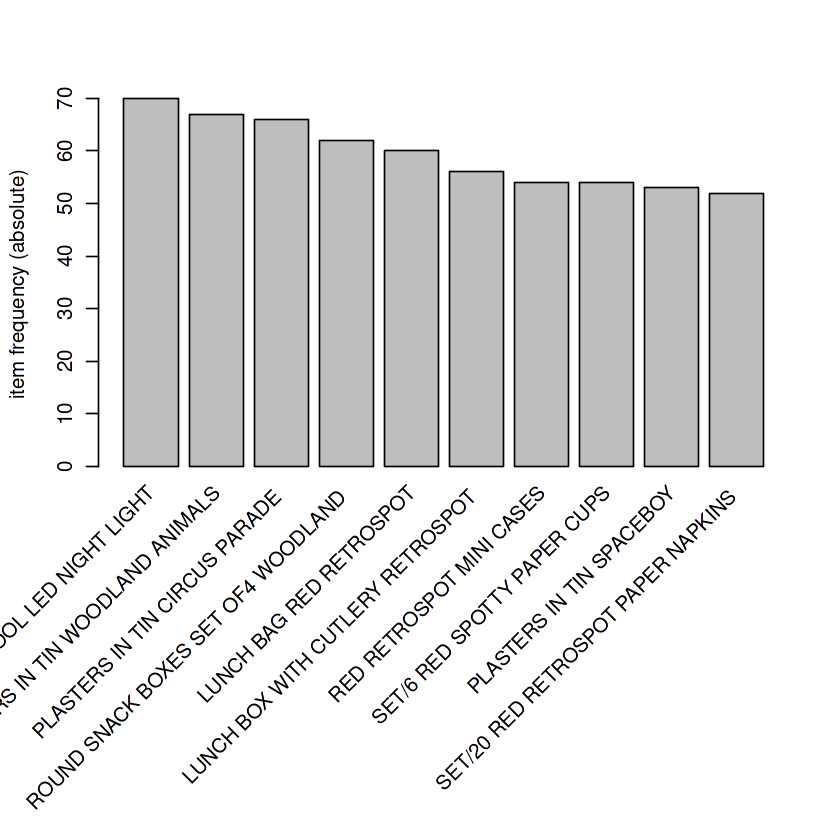

In [208]:
itemFrequencyPlot(transacoes, topN = 10, type = 'absolute')

In [209]:
summary(transacoes)

transactions as itemMatrix in sparse format with
 379 rows (elements/itemsets/transactions) and
 1540 columns (items) and a density of 0.01357811 

most frequent items:
      RED TOADSTOOL LED NIGHT LIGHT    PLASTERS IN TIN WOODLAND ANIMALS 
                                 70                                  67 
     PLASTERS IN TIN CIRCUS PARADE  ROUND SNACK BOXES SET OF4 WOODLAND  
                                 66                                  62 
            LUNCH BAG RED RETROSPOT                             (Other) 
                                 60                                7600 

element (itemset/transaction) length distribution:
sizes
  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19 
  2  14   6   6  12  11   9   9  15  20  11  10  15  11   9  12   8  16  14  12 
 20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39 
 14  11  11   9   5   6   9   4   7   6   4   2   3   8   3   5   3   2   3   3 
 40  41  42

Aplicando APRIORI

In [210]:
regras = apriori(transacoes,
                parameter = list(conf = 0.7, supp = 0.01, minlen = 2))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.7    0.1    1 none FALSE            TRUE       5    0.01      2
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 3 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[1540 item(s), 379 transaction(s)] done [0.00s].
sorting and recoding items ... [544 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 5 6 7 8 9 10 done [0.02s].
writing ... [87802 rule(s)] done [0.01s].
creating S4 object  ... done [0.02s].


Foram encontradas 84802 regras de associação.


In [211]:
#Filtrando regras redundantes

regras_clean = regras[!is.redundant(regras)]

In [212]:
summary(regras_clean)

set of 14653 rules

rule length distribution (lhs + rhs):sizes
   2    3    4    5    6 
 241 6495 7090  800   27 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   3.000   4.000   3.582   4.000   6.000 

summary of quality measures:
    support          confidence        coverage            lift       
 Min.   :0.01055   Min.   :0.7000   Min.   :0.01055   Min.   : 3.790  
 1st Qu.:0.01055   1st Qu.:0.8000   1st Qu.:0.01055   1st Qu.: 5.885  
 Median :0.01055   Median :0.9000   Median :0.01319   Median : 7.774  
 Mean   :0.01247   Mean   :0.8983   Mean   :0.01417   Mean   :10.915  
 3rd Qu.:0.01319   3rd Qu.:1.0000   3rd Qu.:0.01583   3rd Qu.:13.536  
 Max.   :0.12665   Max.   :1.0000   Max.   :0.14248   Max.   :75.800  
     count       
 Min.   : 4.000  
 1st Qu.: 4.000  
 Median : 4.000  
 Mean   : 4.726  
 3rd Qu.: 5.000  
 Max.   :48.000  

mining info:
       data ntransactions support confidence
 transacoes           379    0.01        0.7
                             

### Inspecionando regras, pelo parâmetro 'confidence'

In [213]:
inspect(sort(regras_clean[1:5], by = 'confidence', decreasing = T))

    lhs                                 rhs                              support confidence   coverage      lift count
[1] {JUMBO BAG PINK VINTAGE PAISLEY} => {JUMBO BAG WOODLAND ANIMALS}  0.01055409        1.0 0.01055409 12.633333     4
[2] {REGENCY SUGAR TONGS}            => {REGENCY CAKESTAND 3 TIER}    0.01055409        1.0 0.01055409  7.734694     4
[3] {MINI LADLE LOVE HEART RED }     => {LUNCH BAG RED RETROSPOT}     0.01055409        1.0 0.01055409  6.316667     4
[4] {ROLL WRAP 50'S CHRISTMAS}       => {ROLL WRAP VINTAGE CHRISTMAS} 0.01055409        0.8 0.01319261 37.900000     4
[5] {EDWARDIAN PARASOL PINK}         => {LUNCH BAG WOODLAND}          0.01055409        0.8 0.01319261  6.591304     4


Visualizando regras encontradas (top_20/confidence)

In [214]:
plot(head(sort(regras_clean, by = 'confidence', decreasing = T), 20), measure = "support", shading = "confidence", method = "graph", engine = "html")

HTML widgets cannot be represented in plain text (need html)

### Inspecionando regras encontradas pelo parâmetro 'support'

Inspecionando as top_10 regras

In [215]:
inspect(head(sort(regras_clean, by = 'support', decreasing = T),10))

     lhs                                       rhs                                     support confidence  coverage     lift count
[1]  {SET/6 RED SPOTTY PAPER PLATES}        => {SET/6 RED SPOTTY PAPER CUPS}         0.1266491  0.9600000 0.1319261 6.737778    48
[2]  {SET/6 RED SPOTTY PAPER CUPS}          => {SET/6 RED SPOTTY PAPER PLATES}       0.1266491  0.8888889 0.1424802 6.737778    48
[3]  {PLASTERS IN TIN SPACEBOY}             => {PLASTERS IN TIN WOODLAND ANIMALS}    0.1081794  0.7735849 0.1398417 4.375950    41
[4]  {SET/6 RED SPOTTY PAPER PLATES}        => {SET/20 RED RETROSPOT PAPER NAPKINS } 0.1055409  0.8000000 0.1319261 5.830769    40
[5]  {SET/20 RED RETROSPOT PAPER NAPKINS }  => {SET/6 RED SPOTTY PAPER PLATES}       0.1055409  0.7692308 0.1372032 5.830769    40
[6]  {SET/20 RED RETROSPOT PAPER NAPKINS }  => {SET/6 RED SPOTTY PAPER CUPS}         0.1055409  0.7692308 0.1372032 5.398860    40
[7]  {SET/6 RED SPOTTY PAPER CUPS}          => {SET/20 RED RETROSPOT PAPER NAPKINS 

Como vimos acima, temos os top_10 produtos mais frequentes na nossa base de dados, vamos colher a regra de associação mais forte para cada uma delas, e salvar um arquivo.

In [216]:
itens_frequentes = names(itemFrequency(transacoes)[1:10])

In [217]:
#Criando DF para armazenar o resultado
resultado_df <- data.frame(consequent = character(),
                            antecedent = character(),
                            support = numeric(),
                            confidence = numeric(),
                            lift = numeric(),
                            stringsAsFactors = FALSE)


In [218]:
# Criando função para pesquisa
pesquisa = function(produto){

    regras = apriori(transacoes,
                    parameter = list(conf = 0.7, supp = 0.01, minlen = 2, target = 'rules'),
                    appearance = list(rhs = produto, default = "lhs"))

    regra_sorted = head(sort(regras, by = c('confidence', 'lift'), decreasing = T), 1)
 
    return(as(regra_sorted, 'data.frame'))
    
    }

In [219]:
# aplicando função aos itens frequentes
for (item in itens_frequentes){
    
    resultado_df = rbind(resultado_df, pesquisa(item))
        
}

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.7    0.1    1 none FALSE            TRUE       5    0.01      2
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 3 

set item appearances ...[1 item(s)] done [0.00s].
set transactions ...[1540 item(s), 379 transaction(s)] done [0.00s].
sorting and recoding items ... [544 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 5 6 7 8 9 10 done [0.02s].
writing ... [92 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].
Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.7    0.1    1 none FALSE            TRUE       5    0.01      2
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load 

Visualizando regras dos top_10 produtos frequentes!

In [220]:
resultado_df

,rules,support,confidence,coverage,lift,count
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
7,"{RED RETROSPOT CHILDRENS UMBRELLA,PINK POLKADOT CHILDRENS UMBRELLA} => {RED TOADSTOOL LED NIGHT LIGHT}",0.01055409,1,0.01055409,5.414286,4
1,{BLUE ROSE FABRIC MIRROR} => {PLASTERS IN TIN WOODLAND ANIMALS},0.01055409,1,0.01055409,5.656716,4
11,{CLASSIC CAFE SUGAR DISPENSER} => {PLASTERS IN TIN CIRCUS PARADE },0.01055409,1,0.01055409,5.742424,4
3,"{ALARM CLOCK BAKELIKE GREEN,WOODLAND STICKERS} => {ROUND SNACK BOXES SET OF4 WOODLAND }",0.01055409,1,0.01055409,6.112903,4
12,{MINI LADLE LOVE HEART RED } => {LUNCH BAG RED RETROSPOT},0.01055409,1,0.01055409,6.316667,4
13,{DOORMAT ENGLISH ROSE } => {LUNCH BOX WITH CUTLERY RETROSPOT },0.01055409,1,0.01055409,6.767857,4
31,"{OFFICE MUG WARMER CHOC+BLUE,OFFICE MUG WARMER POLKADOT} => {RED RETROSPOT MINI CASES}",0.01055409,1,0.01055409,7.018519,4
8,"{SET/6 RED SPOTTY PAPER PLATES,RIBBON REEL POLKADOTS } => {SET/6 RED SPOTTY PAPER CUPS}",0.01055409,1,0.01055409,7.018519,4
14,{CHARLOTTE BAG VINTAGE ALPHABET } => {PLASTERS IN TIN SPACEBOY},0.01055409,1,0.01055409,7.150943,4


In [221]:
#separando antecedente/consequente
resultado_df = separate(resultado_df, 'rules', into = c('antecedente', 'consequente'), sep = '=>')

#removendo chaves
resultado_df$antecedente = gsub('\\{|\\}', "", resultado_df$antecedente)
resultado_df$consequente = gsub('\\{|\\}', "", resultado_df$consequente)

In [222]:
resultado_df

,antecedente,consequente,support,confidence,coverage,lift,count
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
7,"RED RETROSPOT CHILDRENS UMBRELLA,PINK POLKADOT CHILDRENS UMBRELLA",RED TOADSTOOL LED NIGHT LIGHT,0.01055409,1,0.01055409,5.414286,4
1,BLUE ROSE FABRIC MIRROR,PLASTERS IN TIN WOODLAND ANIMALS,0.01055409,1,0.01055409,5.656716,4
11,CLASSIC CAFE SUGAR DISPENSER,PLASTERS IN TIN CIRCUS PARADE,0.01055409,1,0.01055409,5.742424,4
3,"ALARM CLOCK BAKELIKE GREEN,WOODLAND STICKERS",ROUND SNACK BOXES SET OF4 WOODLAND,0.01055409,1,0.01055409,6.112903,4
12,MINI LADLE LOVE HEART RED,LUNCH BAG RED RETROSPOT,0.01055409,1,0.01055409,6.316667,4
13,DOORMAT ENGLISH ROSE,LUNCH BOX WITH CUTLERY RETROSPOT,0.01055409,1,0.01055409,6.767857,4
31,"OFFICE MUG WARMER CHOC+BLUE,OFFICE MUG WARMER POLKADOT",RED RETROSPOT MINI CASES,0.01055409,1,0.01055409,7.018519,4
8,"SET/6 RED SPOTTY PAPER PLATES,RIBBON REEL POLKADOTS",SET/6 RED SPOTTY PAPER CUPS,0.01055409,1,0.01055409,7.018519,4
14,CHARLOTTE BAG VINTAGE ALPHABET,PLASTERS IN TIN SPACEBOY,0.01055409,1,0.01055409,7.150943,4


In [224]:
#salvando base de dados em arquivo .csv

write.csv(resultado_df, 'top_10_regras.csv', sep = ',', row.names = F)

## Conclusão

Como resultado, temos um arquivo contendo a regra mais forte para cada um dos itens mais frequente da nossa base de dados. Estas informações podem fomentar, por exemplo, e-mails marketing ou recomendações on-line.